In [20]:
import numpy as np
from scipy.special import gamma, gammaln
import random
from collections import Counter
import pydot
from math import exp

#### 0. Generate Corpus

Each sublist in corpus represent a document

In [34]:
sim = hLDA(corpus, 10, 0.01, 0.5 ,1, 1000 , 3)

AttributeError: 'numpy.ndarray' object has no attribute 'count'

In [32]:
sim2 = hLDA(corpus, 10, 0.01, 0.5 ,1, 1000 , 4)

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


In [183]:
sim3 = hLDA(corpus, 10, 0.01, 0.5 ,1, 1000 , 5)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


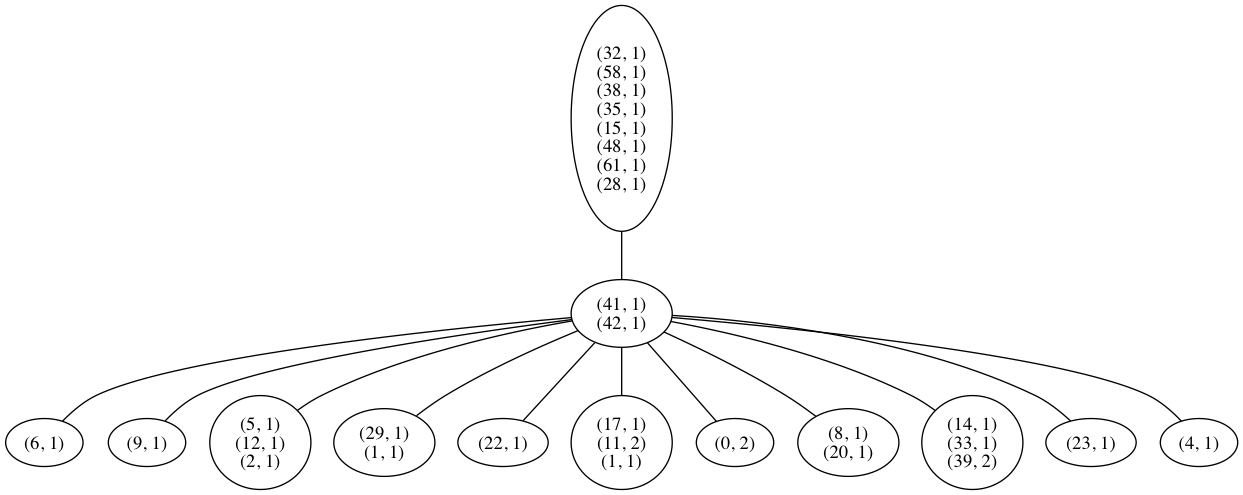

In [31]:
HLDA_plot(sim,8,True)

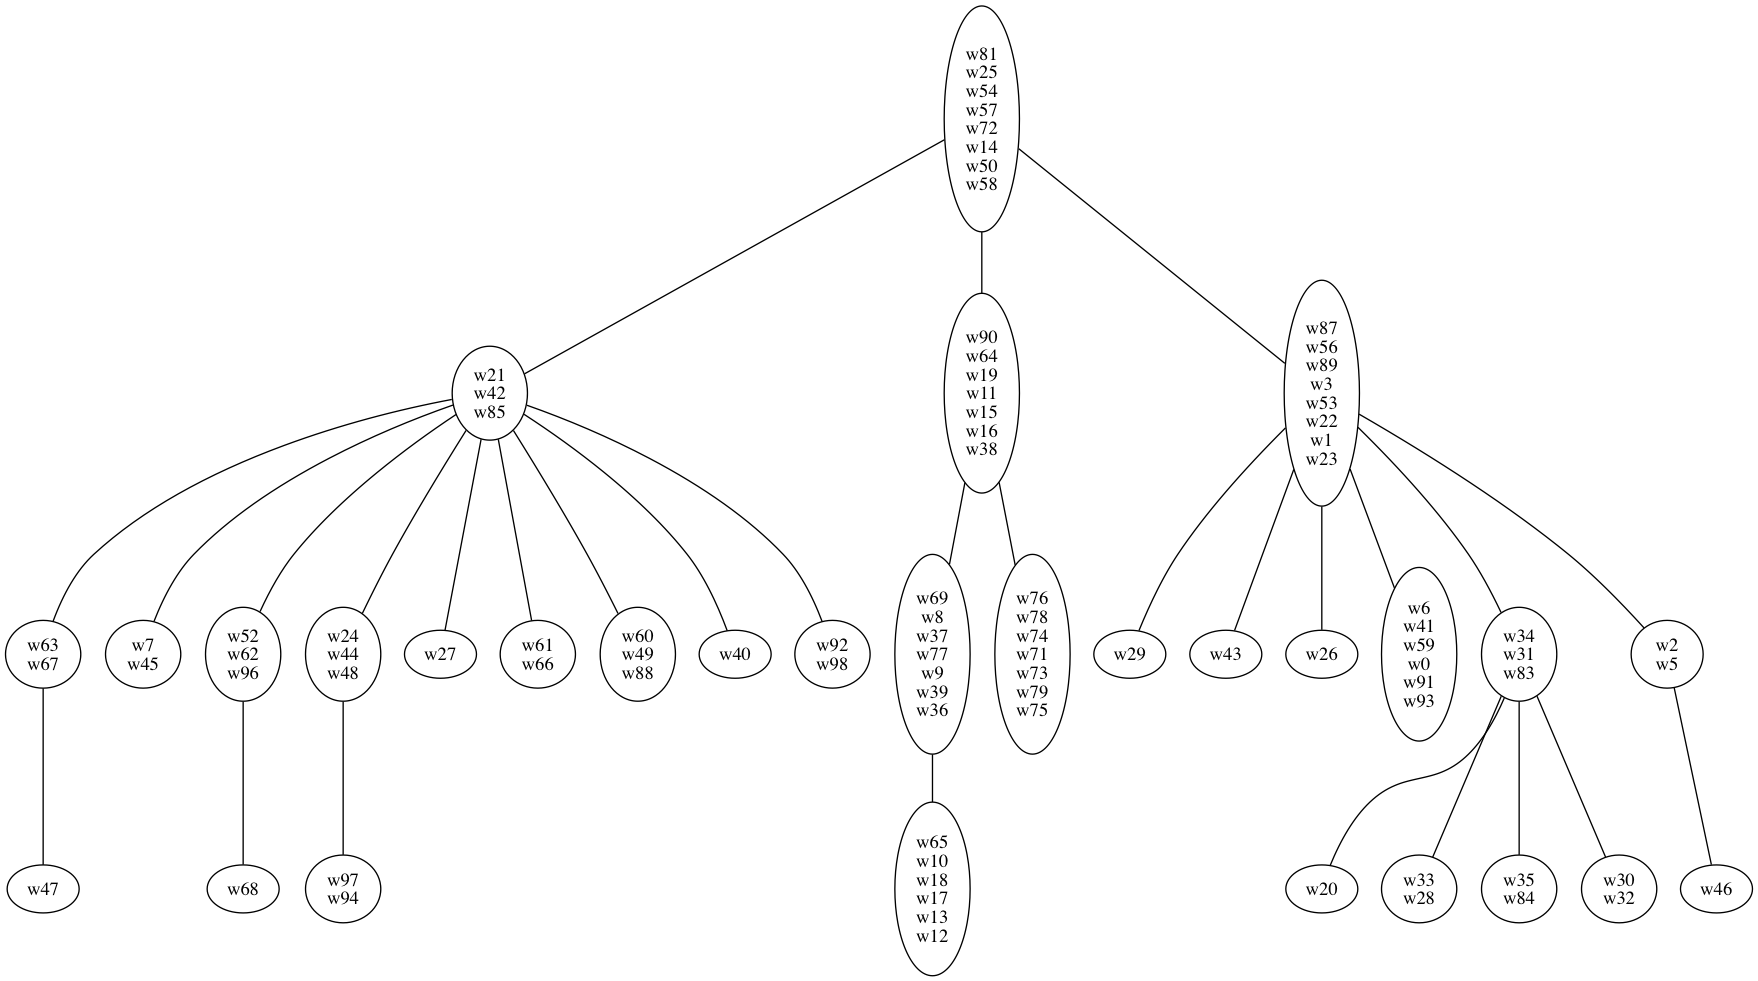

In [190]:
HLDA_plot(sim2,8,True)

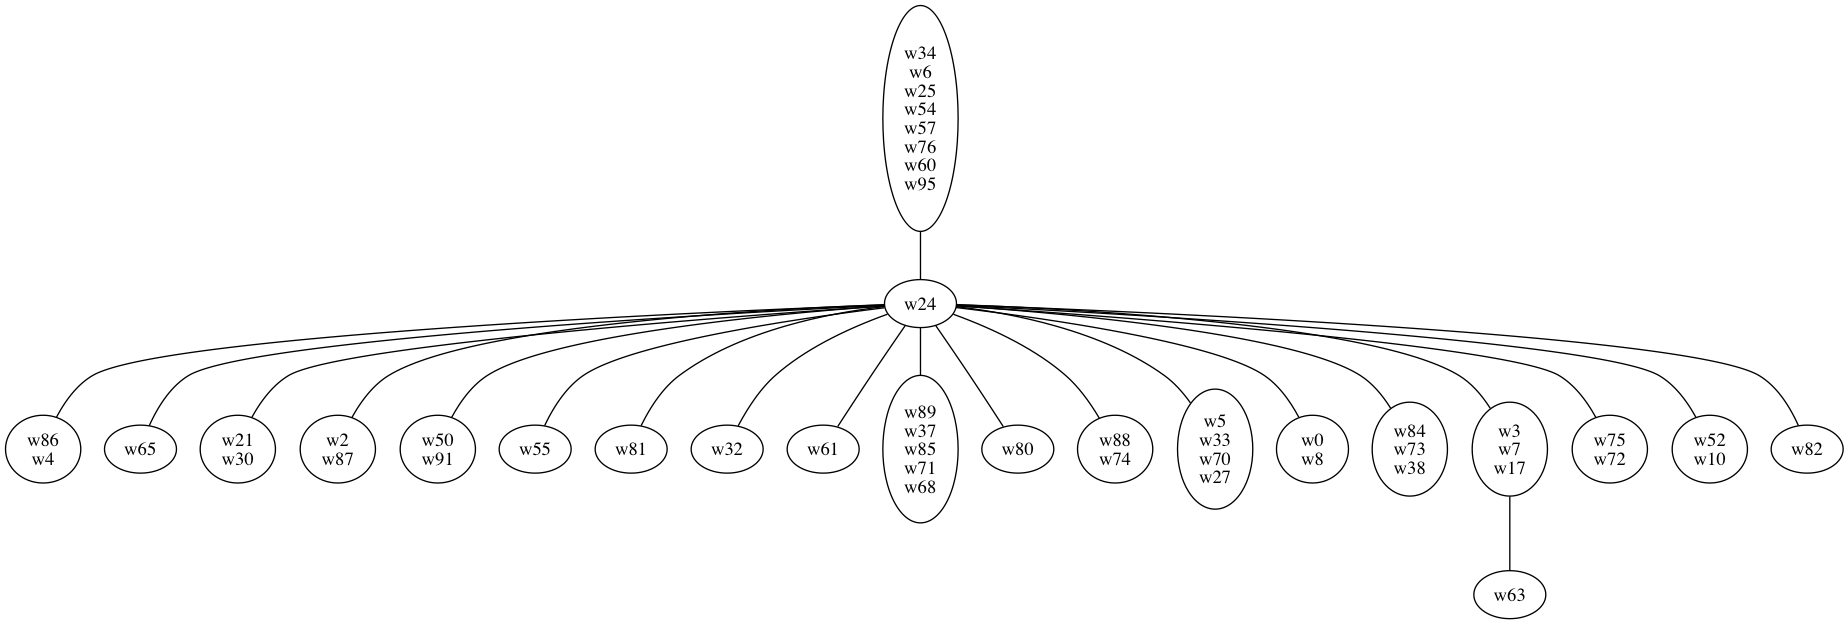

In [192]:
HLDA_plot(sim3)

## hLDA

In [35]:
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim

tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list
en_stop = get_stop_words('en')

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

# create sample documents
doc_a = "Batman became popular soon after his introduction and gained his own comic book title, Batman, in 1940."

doc_b = "In 1971, Trump moved to Manhattan, where he became involved in larger construction projects, and used attractive architectural design to win public recognition."

doc_c = "Batman is, in his everyday identity, Bruce Wayne, a wealthy American business magnate living in Gotham City."

doc_d = "In 2001, Trump completed Trump World Tower, a 72-story residential tower across from the United Nations Headquarters."

doc_e = " Unlike most superheroes, Batman does not possess any superpowers; rather, he relies on his genius intellect, physical prowess, martial arts abilities, detective skills, science and technology, vast wealth, intimidation, and indomitable will. "

# compile sample documents into a list
doc_set = [doc_a, doc_b, doc_c, doc_d, doc_e]

# list for tokenized documents in loop
texts = []

# loop through document list
for i in doc_set:

    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]

    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]

    # add tokens to list
    texts.append(stemmed_tokens)

# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

In [36]:
corpus

[[(0, 2),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1)],
 [(1, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1)],
 [(0, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1)],
 [(11, 2),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 2),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1)],
 [(0, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1)]]

In [6]:
def CRP(topic, phi):
    '''CRP gives the probability of topic assignment for specific vocabulary'''
    '''Return a j * 1 vector, where j is the number of topic'''
    cm = np.empty(len(topic)+1)
    m = sum([len(x) for x in topic])
    cm[0] = phi / (phi + m) # prob for new topic
    for i, word in enumerate(topic):
        cm[i+1] = len(word) / (phi + m) # prob for existing topics
    return cm
  
def node_sampling(corpus_s, phi):
    '''Node sampling samples the number of topics for next level'''
    topic = []    
    for corpus in corpus_s:
        for word in corpus:
            cm = CRP(topic, phi)
            theta = np.random.multinomial(1, (cm/sum(cm))).argmax()
            if theta == 0:
                # create new topic
                topic.append([word])
            else:
                # existing topic
                topic[theta-1].append(word)
    return topic

In [7]:
def Z(corpus_s, topic, alpha, beta):
    '''Z distributes each vocabulary to topics'''
    '''Return a n * 1 vector, where n is the number of vocabularies'''
    n_vocab = sum([len(x) for x in corpus_s])
    # zm: n * 1
    # return the assignment of each vocabulary
    t_zm = np.zeros(n_vocab).astype('int')
    # z_assigned: j * 1
    # return a list of list topic where stores assigned vocabularies in each sublist
    z_assigned = [[] for _ in topic]
    z_doc = [[] for _ in topic]
    z_tmp = np.zeros((n_vocab, len(topic)))
    assigned = np.zeros((len(corpus_s), len(topic)))
    n = 0
    for i in range(len(corpus_s)):
        for d in range(len(corpus_s[i])): 
            wi = corpus_s[i][d]   
            for j in range(len(topic)):
                lik = (z_assigned[j].count(wi) + beta) / (assigned[i, j] + n_vocab * beta)
                pri = (len(z_assigned[j]) + alpha) / ((len(corpus_s[i]) - 1) + len(topic) * alpha)
                z_tmp[n, j] = lik * pri
                t_zm[n] = np.random.multinomial(1, (z_tmp[n,:]/sum(z_tmp[n,:]))).argmax()
            z_assigned[t_zm[n]].append(wi)
            z_doc[t_zm[n]].append(i)
            assigned[i, t_zm[n]] += 1
            n += 1
    z_assigned = [x for x in z_assigned if x != []]
    z_doc = [x for x in z_doc if x != []]
    return z_assigned, z_doc

In [8]:
def CRP_prior(corpus_s, doc, phi):
    cp = np.empty((len(corpus_s), len(doc)))
    for i, corpus in enumerate(corpus_s):
        p_topic = [[x for x in doc[j] if x != i] for j in range(len(doc))]
        tmp = CRP(p_topic, phi)
        cp[(i, ):] = tmp[1:]
    return cp

In [9]:
def likelihood(corpus_s, topic, eta):
    w_m = np.empty((len(corpus_s), len(topic)))
    allword_topic = [word  for t in topic for word in t]
    n_vocab = sum([len(x) for x in corpus_s])
    for i, corpus in enumerate(corpus_s):
        prob_result = []
        for j in range(len(topic)):
            current_topic = topic[j]
            n_word_topic = len(current_topic)
            prev_dominator = 1
            later_numerator = 1
            prob_word = 1  

            overlap = [val for val in set(corpus) if val in current_topic]
            
            prev_numerator = gammaln(len(current_topic) - len(overlap) + n_vocab * 1)
            later_dominator = gammaln(len(current_topic) + n_vocab * 1)
            for word in corpus:                
                corpus_list = corpus                
                if current_topic.count(word) - corpus_list.count(word) < 0 :
                    a = 0
                else:
                    a = current_topic.count(word) - corpus_list.count(word)
                
                prev_dominator += gammaln(a + 1)
                later_numerator += gammaln(current_topic.count(word) + 1)
           
            prev = prev_numerator - prev_dominator
            later = later_numerator - later_dominator
            
            like = prev + later 
            w_m[i, j] = exp(like)
    return w_m

In [10]:
def post(w_m, c_p):
    c_m_nume = (w_m * c_p)
    c_m_deno = c_m_nume.sum(axis = 1)
    c_m = c_m_nume/c_m_deno[:, np.newaxis]
    return np.array(c_m)

In [11]:
most_common = lambda x: Counter(x).most_common(1)[0][0]

In [12]:
def wn(c_m, corpus_s, topic):
    wn_ass = []
    wn_topic = [[] for _ in range(len(topic))]
    for i, corpus in enumerate(corpus_s):
        for word in corpus:
            theta = np.random.multinomial(1, c_m[i]).argmax()
            wn_ass.append(theta)
            wn_topic[theta].append(word)
    return np.array(wn_ass), wn_topic

In [13]:
def gibbs(corpus_s, topic, alpha, beta, phi, eta, ite):
    n_vocab = sum([len(x) for x in corpus_s])
    gibbs = np.empty((n_vocab, ite)).astype('int')
   
    for i in range(ite):
        z_topic, z_doc = Z(corpus_s, topic, alpha, beta)
        c_p = CRP_prior(corpus_s, z_doc, phi)
        w_m = likelihood(corpus_s, z_topic, eta)
        c_m = post(w_m, c_p)
        gibbs[:, i], w_topic = wn(c_m, corpus_s, z_topic) 
    # drop first 1/10 data
    gibbs = gibbs[:, int(ite/10):]
    theta = [most_common(gibbs[x]) for x in range(n_vocab)]
    
    n_topic = max(theta)+1
    
    wn_topic = [[] for _ in range(n_topic)]
    wn_doc_topic = [[] for _ in range(n_topic)]

    doc = 0
    n = 0
    for i, corpus_s in enumerate(corpus_s):
        if doc == i:
            for word in corpus_s:
                wn_doc_topic[theta[n]].append(word)
                n += 1
            for j in range(n_topic):
                if wn_doc_topic[j] != []:
                    wn_topic[j].append(wn_doc_topic[j])
        wn_doc_topic = [[] for _ in range(n_topic)]        
        doc += 1
    wn_topic = [x for x in wn_topic if x != []]
    return wn_topic

In [14]:
def hLDA(corpus_s, alpha, beta, phi, eta, ite, level):
    
    topic = node_sampling(corpus_s, phi)
    
    hLDA_tree = [[] for _ in range(level)]
    tmp_tree = []
    node = [[] for _ in range(level+1)]
    node[0].append(1)
    
    for i in range(level):
        if i == 0:
            wn_topic = gibbs(corpus_s, topic, alpha, beta, phi, eta, ite)
            topic = set([x for list in wn_topic[0] for x in list])
            hLDA_tree[0].append(topic)
            tmp_tree.append(wn_topic[1:])
            tmp_tree = tmp_tree[0]
            node[1].append(len(wn_topic[1:]))
        else:
            for j in range(sum(node[i])):
                if tmp_tree == []:
                    break
                wn_topic = gibbs(tmp_tree[0], topic, alpha, beta, phi, eta, ite)
                topic = set([x for list in wn_topic[0] for x in list])
                hLDA_tree[i].append(topic)
                tmp_tree.remove(tmp_tree[0])
                if wn_topic[1:] != []:
                    tmp_tree.extend(wn_topic[1:])
                node[i+1].append(len(wn_topic[1:]))
        
    return hLDA_tree, node[:level]

In [22]:
ans = hLDA(texts,  1, 0.01, 0.1 ,1, 1000 , 4)

In [23]:
ans

([[{'1940',
    '1971',
    '2001',
    '72',
    'abil',
    'across',
    'american',
    'architectur',
    'art',
    'attract',
    'batman',
    'becam',
    'book',
    'bruce',
    'busi',
    'citi',
    'comic',
    'complet',
    'construct',
    'design',
    'detect',
    'everyday',
    'gain',
    'geniu',
    'gotham',
    'headquart',
    'ident',
    'indomit',
    'intellect',
    'intimid',
    'introduct',
    'involv',
    'larger',
    'live',
    'magnat',
    'manhattan',
    'martial',
    'move',
    'nation',
    'physic',
    'popular',
    'possess',
    'project',
    'prowess',
    'public',
    'rather',
    'recognit',
    'reli',
    'residenti',
    'scienc',
    'skill',
    'soon',
    'stori',
    'superhero',
    'superpow',
    'technolog',
    'titl',
    'tower',
    'trump',
    'unit',
    'unlik',
    'use',
    'vast',
    'wayn',
    'wealth',
    'wealthi',
    'will',
    'win',
    'world'}],
  [],
  [],
  []],
 [[1], [0], [], []])

## Plot Function

In [27]:
def HLDA_plot(hLDA_object,Len = 8, save = False):
    
    from IPython.display import Image, display
    def viewPydot(pdot):
        plt = Image(pdot.create_png())
        display(plt)

    words = hLDA_object[0]
    struc = hLDA_object[1]
      
    graph = pydot.Dot(graph_type='graph')
    end_index = [np.insert(np.cumsum(i),0,0) for i in struc]
    for level in range(len(struc)-1):

        leaf_level = level + 1
        leaf_word = words[leaf_level]
        leaf_struc = struc[leaf_level]
        word = words[level]
        end_leaf_index = end_index[leaf_level]

        for len_root in range(len(word)):
            #print(list(word[len_root]))
            root_word = '\n'.join(str(v) for v in list(word[len_root])[:Len])
            leaf_index = leaf_struc[len_root]  
            start = end_leaf_index[len_root]
            end = end_leaf_index[len_root+1]
            lf = leaf_word[start:end]  
            for l in lf:
                #print(list(l))
                leaf_w = '\n'.join(str(v) for v in list(l)[:Len]) 
                edge = pydot.Edge(root_word, leaf_w)
                graph.add_edge(edge)
    if save == True:
        graph.write_png('graph.png')
    viewPydot(graph)

In [28]:
HLDA_plot(ans)